<a href="https://colab.research.google.com/github/cagdastopcu/omission-of-visual-stimuli/blob/main/a_model_for_memory_firing_rate_VIP_SST_PYR_neurons_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from scipy import linalg
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from google.colab import files

In [ ]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N']      = 20                 # number of neurons
model['nPYR']    = 4                  #number of PYR inhib. neurons
model['nVIP']    = 8                  #number of VIP inhib. neurons
model['nSST']    = 8                  #number of SST inhib. neurons
model['g']      = 0.95                 # gain of synaptic weights in pool
model['sp']     = 0.25                 # fraction of weights that are nonzero
model['tau']    = 10                   # neural membrane time constant in ms
model['dt']     = 0.1                  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x) # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn']    = 20                   # size of the input layer
model['gIn']    = 10.0                 # gain of the input weights
model['spIn']   = 0.05                 # sparsity of input->pool connectivity
model['burnIn'] = 10                   # time before input starts
model['durIn']  = 1                    # time for which an input is active in ms
model['ISI']    = 0                    # time between inputs in ms
model['nonlinIn'] = lambda x: x        # best to keep the input linear

(8, 8)
2.4010206495296185


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


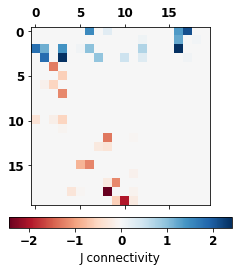

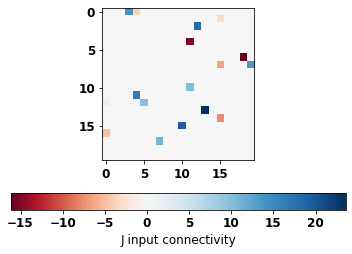

In [ ]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
JMat = np.zeros((model['N'],model['N']))
randPYR      = np.abs(np.random.normal(0, 1, size=(model['nPYR'], model['N'])))
spMat        = np.random.uniform(0, 1, size=(model['nPYR'], model['N'])) \
                <= model['sp']

JPYR = np.multiply(randPYR, spMat) \
                * model['g'] / math.sqrt(model['nPYR'] * model['sp']/2)
#print(JPYR.shape)

randSST      = -(np.abs(np.random.normal(0, 1, size=(model['nSST'], model['nPYR']))))
spMat        = np.random.uniform(0, 1, size=(model['nSST'],model['nPYR'])) \
                <= model['sp']

JSST = np.multiply(randSST, spMat) \
                * model['g'] / math.sqrt(model['nSST'] * model['sp']/2)
#print(JSST.shape)


randVIP      = -(np.abs(np.random.normal(0, 1, size=(model['nVIP'], model['nVIP']))))
spMat        = np.random.uniform(0, 1, size=(model['nVIP'], model['nVIP'])) \
                <= model['sp']

JVIP = np.multiply(randVIP, spMat) \
                * model['g'] / math.sqrt(model['nVIP'] * model['sp']/2)
print(JVIP.shape)

JMat[:model['nPYR'],:] = JPYR
JMat[model['nPYR']:model['nPYR']+model['nSST'],:model['nPYR']] = JSST
JMat[model['nPYR']+model['nSST']:model['nPYR']+model['nSST']+model['nVIP'],model['nPYR']:model['nPYR']+model['nSST']] = JVIP
model['J']   = JMat

#plt.figure(figsize=[10, 10],dpi=600)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)    
plt.matshow(model['J'],cmap='bwr')

norm = mcolors.TwoSlopeNorm(vmin=model['J'].min(), vmax = model['J'].max(), vcenter=0)


# plt.colorbar(label="J", orientation="horizontal",pad=0.05)
plt.imshow(model['J'], cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(label="J connectivity", orientation="horizontal",pad=0.05)

#plt.show()

#plt.savefig('JMatrix.png', dpi=600,bbox_inches='tight')
#files.download("JMatrix.png") 

print(model['J'].max())
#indexInhib = np.random.choice(randMat.shape[0], model['nVIP'], replace=False)
# Create the input weight matrix.
randMatIn    = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn      = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) \
                <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) \
                * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

plt.figure()
norm = mcolors.TwoSlopeNorm(vmin=model['Jin'].min(), vmax = model['Jin'].max(), vcenter=0)


# plt.colorbar(label="J", orientation="horizontal",pad=0.05)
plt.imshow(model['Jin'], cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(label="J input connectivity", orientation="horizontal")

# New Section

In [ ]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.
  
  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  if np.any(input_layer):
    model['Jin'][np.nonzero(input_layer),:] = model['Jin'][np.nonzero(input_layer),:]+0.1
    #model['Jin'][np.nonzero(input_layer),:] = 1.1*model['Jin'][np.nonzero(input_layer),:]+0.1

  return updated_rates, model['Jin']


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    #val = 2
    val = np.random.randint(0, model['nIn']) + 1
    #val = np.sin(2*np.pi*model['dt']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)
    
  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn']+1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:,:]

  return onehot, input_stream

(300,)
(20, 300)


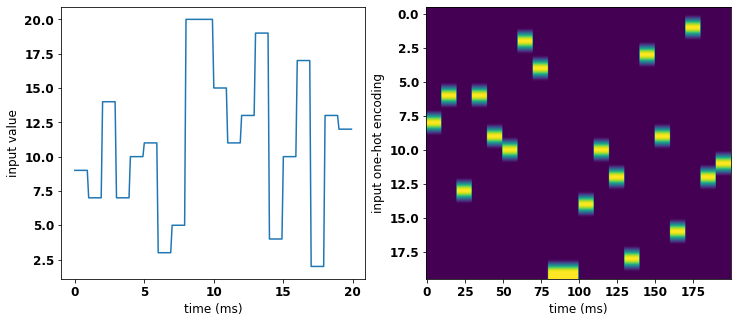

In [ ]:
# Look at an example input stream.

onehot, stream = make_input(20, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:]);
ax[0].set_xlabel('time (ms)');
ax[0].set_ylabel('input value');

ax[1].imshow(onehot[:, omit:], aspect='auto');
ax[1].set_xlabel('time (ms)');
ax[1].set_ylabel('input one-hot encoding');

print(stream.shape)
print(onehot.shape)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


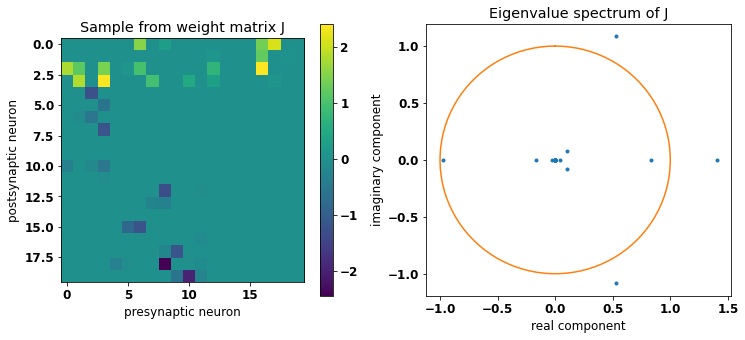

In [ ]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h=ax[0].imshow(model['J'][:showCount,:showCount]);
ax[0].set_title('Sample from weight matrix J');
ax[0].set_xlabel('presynaptic neuron');
ax[0].set_ylabel('postsynaptic neuron');
plt.colorbar(h, ax=ax[0]);

ax[1].plot(np.real(w),np.imag(w),'.');
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100))); # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component');
ax[1].set_ylabel('imaginary component');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

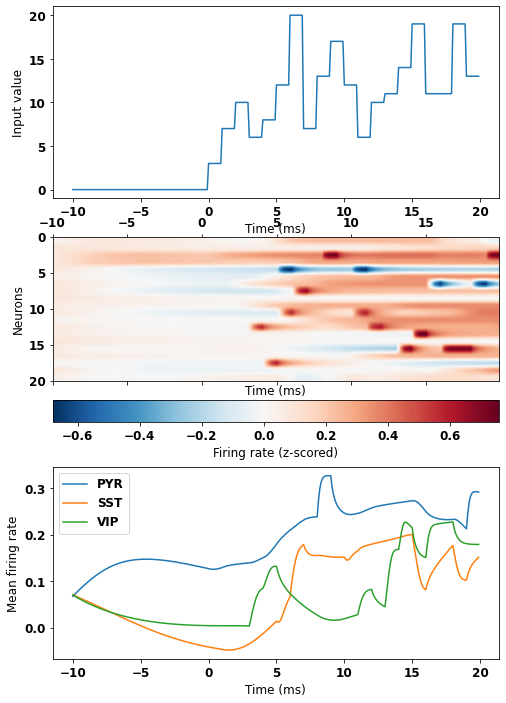

In [ ]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(20, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
inputChangeJ = np.zeros((len(input_stream),model['N'],model['N']))


for t in range(len(input_stream)-1):
  firing_rates[:,t+1],inputChangeJ[t,:] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(3, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream);
ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Input value');

extents = [simulation_time[0],simulation_time[-1], model['N'], 0]

ax[1].matshow(firing_rates, aspect='auto', extent=extents,cmap='bwr')

norm = mcolors.TwoSlopeNorm(vmin=firing_rates.min(), vmax = firing_rates.max(), vcenter=0)

mappable_ax = ax[1].imshow(firing_rates, aspect='auto', extent=extents, cmap=plt.cm.RdBu_r, norm=norm);

fig.colorbar(mappable_ax,ax=ax[1],label="Firing rate (z-scored)", orientation="horizontal",pad=0.1)

ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Neurons');



pyr, = ax[2].plot(simulation_time,firing_rates[0:model['nPYR'],:].mean(axis=0))
sst, = ax[2].plot(simulation_time,firing_rates[model['nPYR']:model['nPYR']+model['nSST'],:].mean(axis=0))
vip, = ax[2].plot(simulation_time,firing_rates[model['nPYR']+model['nSST']:-1,:].mean(axis=0))
ax[2].legend([pyr, sst, vip], ['PYR', 'SST', 'VIP'])
ax[2].set_xlabel('Time (ms)');
ax[2].set_ylabel('Mean firing rate');

plt.savefig('results.png', dpi=600,bbox_inches='tight')
files.download("results.png") 

(20, 300)


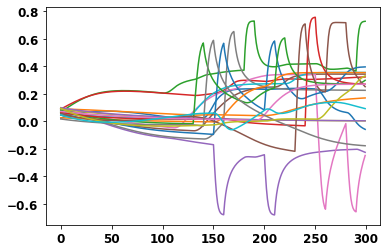

In [ ]:
print(firing_rates.shape)

plt.plot(firing_rates[:,:].T)

In [ ]:
U, s, Vh = linalg.svd(firing_rates)

U.shape,  s.shape, Vh.shape

#plt.scatter(range(400),model['J'].flatten(),linestyle='None',marker='o',facecolors='none', edgecolors='r')
#plt.scatter(range(400),model['J'].flatten(),linestyle='None',marker='+',facecolors='k', edgecolors='k'
#U@s

print(s.min())

0.0005080671610076673


In [ ]:
np.allclose(np.linalg.inv(U), U.transpose())

True

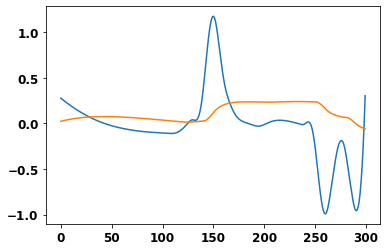

In [ ]:
Zf = savgol_filter(firing_rates[0,:], window_length=29, polyorder=4, deriv=1, delta=0.01)#model['dt']
plt.plot(Zf[:2500])
plt.plot(firing_rates[0,:2500])

array([ 1.        ,  1.        ,  1.        ,  1.        , 17.72638488,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

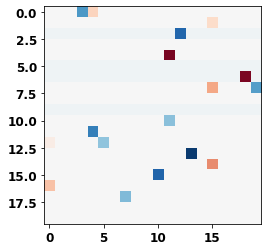

In [ ]:
norm = mcolors.TwoSlopeNorm(vmin=inputChangeJ.min(), vmax = inputChangeJ.max(), vcenter=0)
inputChangeJ.shape
plt.imshow(inputChangeJ[140,:,:], cmap=plt.cm.RdBu, norm=norm)
#a = np.array([0,0,0,1,0])
#a[np.nonzero(a)]
inputChangeJ[180,11,:]